# Tutorial: applying excursion in 1 dimension

## (with GPyTorch)

In [76]:
#generic imports
import numpy as np
import datetime
import os
import json
import yaml
import math
import time
import torch
import gpytorch
import matplotlib.pyplot as plt
%matplotlib inline
np.warnings.filterwarnings('ignore')
from matplotlib import pyplot
pyplot.style.use('dark_background')



#excursion package imports
import excursion
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Step 0: What is excursion?
You can find an explanation [here]()
#TO DO
Also, it is advisable to use a virtualenv with the following [requeriments](https://github.com/irinaespejo/excursion/blob/master/requeriments.txt)

## Step 1: Load

We need to initilize several things and with a specific structure so that it's readable:

-  **True/Black-box function** (this is not a tutorial using funcX, just a simple toy function is all we need) 
-  **Grid**: where do you want to search for next evaluation points?
-  **Gaussian Process**: which kernel and likelihood do you want to use?
-  **Algorithm Options**: which acquisition function? Do you want batch selection? How many points per batch? Which batch method selection?

There are many choices and a user might not know a priori what to use. That is why we have prepared a set of complete examples that you just have to load to get started. These pre-build examples are in `excursion/testcases/fast_1D.py`these `.py` scripts contain initialization for: true/black-box function and grid (the "numerical options"). The files in `excursion/testcases/algorithms/algorithm_specs.yml` are yaml files that contain prestablished Gaussian Processes and Algorithm Options (the "algorithm options"). This way of ordering the init step makes it easy to fix a numerical problem while trying different algorithm configurations and vice versa.

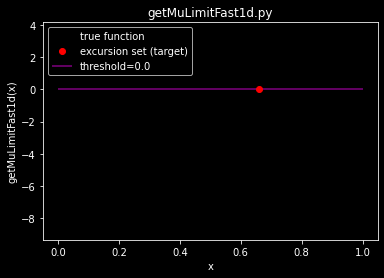

In [77]:
#load testcase
import excursion.testcases.fast_1D as testcase_details
import excursion.testcases.madgraph5atlasval.getMuLimitFast1d as testcase_details

testcase_details.getMuLimitFast1d([[0.75]])


#plot function and thresholds
for func in testcase_details.true_functions:
    X_plot = testcase_details.X_plot
    true = plt.plot(X_plot, func(X_plot), label='true function', color='black', linestyle='--')
    
for thr in testcase_details.thresholds:
    min_X = np.min(testcase_details.X_plot)
    max_X = np.max(testcase_details.X_plot)
    t = plt.hlines(thr, min_X, max_X, colors = 'purple', label='threshold='+str(thr.item()))

#approximate level set for plot purposes
plt.plot([0.66], [0], 'ro', label='excursion set (target)')
plt.xlabel('x')
plt.ylabel('getMuLimitFast1d(x)')
plt.title('getMuLimitFast1d.py')
plt.legend(loc=0)
plt.show()

In [78]:
#load algorithm options
file = open('../excursion/testcases/algorithms/algorithm_specs.yaml', "r")
algorithm_opts = yaml.safe_load(file)
print('algorithm_opts =')
print(json.dumps(algorithm_opts, indent=4))

algorithm_opts =
{
    "example": "getMuLimitFast1d",
    "ninit": 2,
    "nupdates": 4,
    "init_type": "random",
    "likelihood": {
        "type": "GaussianLikelihood",
        "epsilon": 0.0
    },
    "model": {
        "type": "ExactGP",
        "kernel": "RBF",
        "prior": "Constant"
    },
    "acq": {
        "acq_type": "MES_gpu",
        "batch": false,
        "batchtype": "KB",
        "batchsize": 2
    }
}


## Step 2: Init the Gaussian Proces

We initialize the gaussian process and likelihood according to `algorithm_opts['init_type']`

In [79]:
#is there GPU?
if (torch.cuda.is_available()):
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

from excursion import init_gp
model, likelihood = init_gp(testcase_details, \
                            algorithm_opts, \
                            algorithm_opts["ninit"], \
                            device)

# X_init and y_init are random points so that we can fit the GP posterior wrt these points

X_init  tensor([[0.6364],
        [0.4646]], dtype=torch.float64)
y_init  tensor([-0.2427, -1.9450], dtype=torch.float64)


In [80]:
# fit hyperparameters
model.train()
likelihood.train()
excursion.fit_hyperparams(model,likelihood)

torch.Size([100, 1])


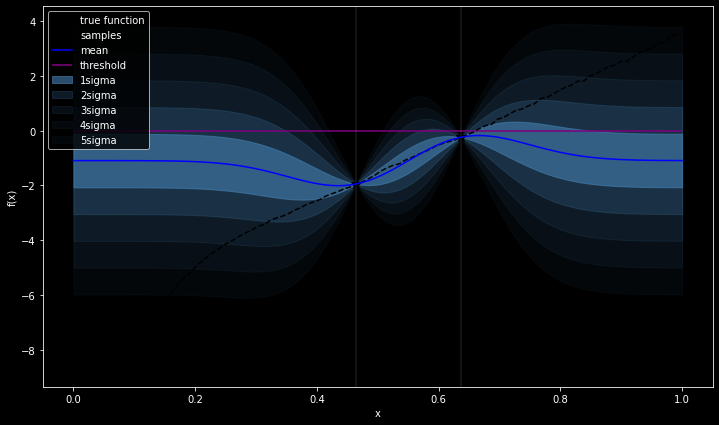

In [81]:
# plot the fitting
import excursion.plotting.onedim as plots
#plots.plot_GP(model, testcase_details)

X_train = model.train_inputs[0]
y_train = model.train_targets
X_plot = torch.from_numpy(testcase_details.X_plot)

    ##mean
likelihood = model.likelihood
likelihood.eval()
model.eval()
prediction = likelihood(model(X_plot))


fig = plt.figure(figsize=(12, 7))
# true function + thresholds
for func in testcase_details.true_functions:
    plt.plot(
    X_plot,
    func(X_plot),
    linestyle="dashed",
    color="black",
    label="true function",
    )

for thr in testcase_details.thresholds:
    min_X = torch.min(testcase_details.plot_X)
    max_X = torch.max(testcase_details.plot_X)
    plt.hlines(thr, min_X, max_X, colors="purple", label="threshold")

plt.plot(X_train, y_train, "k*", color="black", label="samples", markersize=10)
for x in X_train:
    plt.axvline(x, alpha=0.2, color="grey")


print(X_plot.shape)
plt.plot(X_plot.flatten(), prediction.mean.detach(), color="blue", label="mean")


##variance
for i in [1, 2, 3, 4, 5]:
    plt.fill_between(
        X_plot.view(-1),
        prediction.mean.detach().numpy()
        + i * prediction.variance.detach().numpy() ** 0.5,
        prediction.mean.detach().numpy()
        - i * prediction.variance.detach().numpy() ** 0.5,
        color="steelblue",
        alpha=0.6 / i ** 1.5,
        label=str(i) + "sigma",
    )

plt.xlabel("x")
plt.ylabel("f(x)")
plt.legend(loc=0)

## Step 3: Init the ExcursionEstimator

In [82]:
from excursion import ExcursionSetEstimator
# this object keeps internal track of the status of all objects involved
# in excursion at each step
estimator = ExcursionSetEstimator(testcase_details, \
                                  algorithm_opts, \
                                  model, \
                                  likelihood, \
                                  device)

## Step 4:  Smart grid search (active learning)

Iteration  1
x_new  torch.Size([1, 1]) tensor([[0.6970]], dtype=torch.float64)
y_new  torch.Size([1]) tensor([0.4163], dtype=torch.float64)
I didnt get an axis
pct  1.0
Iteration  2
x_new  torch.Size([1, 1]) tensor([[0.]], dtype=torch.float64)
y_new  torch.Size([1]) tensor([-8.7152], dtype=torch.float64)
I didnt get an axis
pct  0.96
Iteration  3
x_new  torch.Size([1, 1]) tensor([[0.9697]], dtype=torch.float64)
y_new  torch.Size([1]) tensor([3.1982], dtype=torch.float64)
I didnt get an axis
pct  1.0
Iteration  4
x_new  torch.Size([1, 1]) tensor([[0.0101]], dtype=torch.float64)
y_new  torch.Size([1]) tensor([-8.7152], dtype=torch.float64)
I didnt get an axis
pct  1.0


<Figure size 432x288 with 0 Axes>

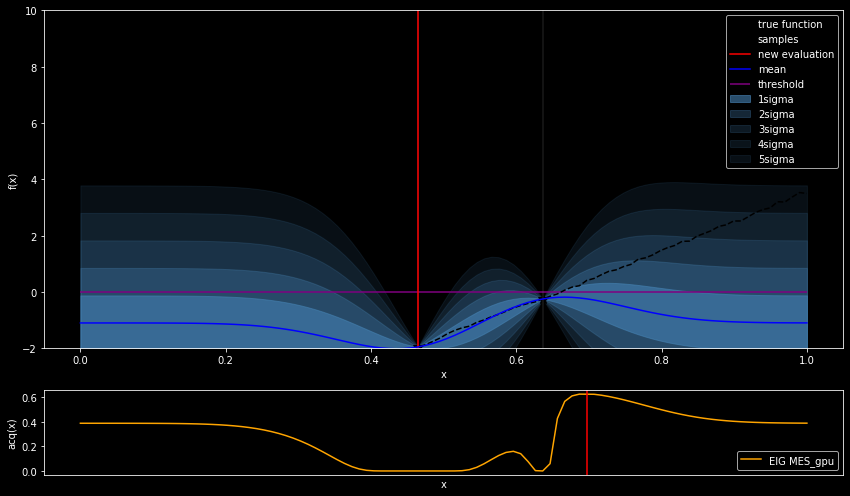

<Figure size 432x288 with 0 Axes>

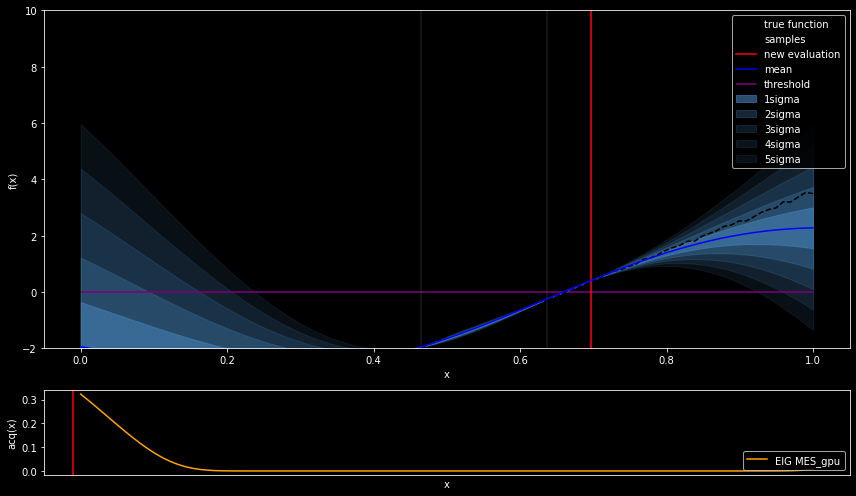

<Figure size 432x288 with 0 Axes>

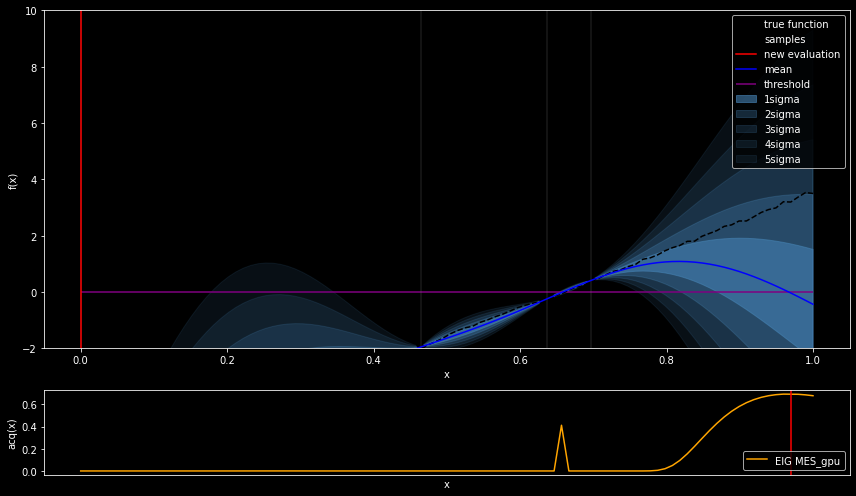

<Figure size 432x288 with 0 Axes>

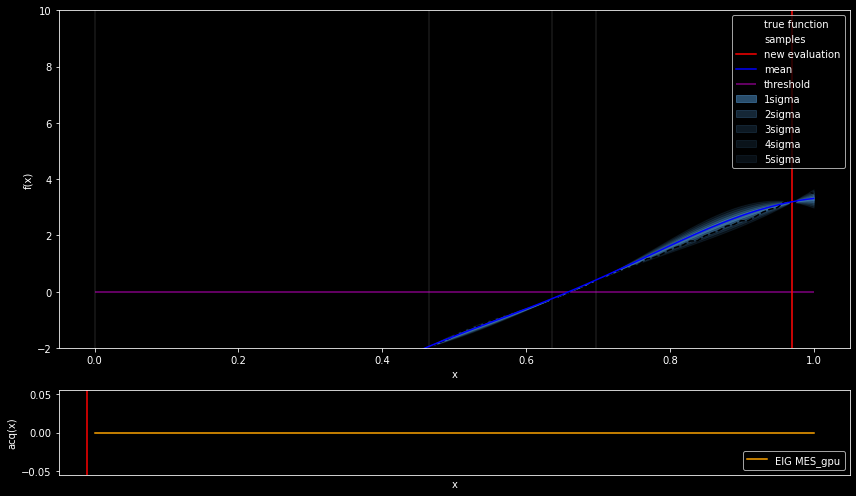

In [83]:
n_updates = algorithm_opts['nupdates']
#save results in folder
timestampStr = datetime.datetime.now().strftime("%d-%b-%Y_%H:%M:%S") + "/"
outputfolder = "../examples/results/" +  timestampStr
os.makedirs(outputfolder)

for iteration in range(1, n_updates+1):    
    #take a step forward: find new points to evaluate
    estimator.step(testcase_details, algorithm_opts, model, likelihood)
    
    #plot the new status
    estimator.plot_status(
            testcase_details, algorithm_opts, model, estimator.acq_values, outputfolder)
    
    #update the posterior of the GP wrt the new points
    model = estimator.update_posterior(testcase_details, algorithm_opts, model, likelihood)
    
    #get diagnostics (accuracy metric)
    estimator.get_diagnostics(testcase_details, model, likelihood)
    
#save results
#estimator.print_results(outputfolder, testcase_details, algorithm_opts)